<a href="https://colab.research.google.com/github/Yash1289/rossmann_sales_prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

**Regression analysis** is a fundamental concept in the field of machine learning . It falls under supervised learning wherein the alogrithms is trained with both input features and output labels. 

Specifically regression analysis is all about data. It helps businesses understand the data points they have and use them – specifically the relationships between data points – to make better decisions, including anything from predicting sales to understanding inventory levels and supply and demand.

In this project we as well will try to predict the future daily sales of Rossmann store for up to six weeks in advance , for the project we have at our disposal two database named *Rossmann Stores Data* that contains all the historical data including sales and the other one called *store* that contains supplemental information about all the stores

For this project we are going to use
  1. Numpy :- For its linear algebra functions and the advantage it offers over list in terms of speed and memory consumed
  2. Pandas :- This will be our primary data analysis library necessary for almost all of our data manipulations jobs
  3. Matplotlib :- Basic visualization library that we need for plotting and graphs
  4. Seaborn :- For more customizable and advanced data visualization
  5. Sklearn :- For all the models and tools that we need for our predictive data analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
#Mounting our google drive so we can acess the files in it through our google colab noteboook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading the first database (Rossmann Stores Data) from our google drive

path1 = "/content/drive/MyDrive/Rossmann Stores Data.csv"
rossmann_df = pd.read_csv(path1 , low_memory = False)

In [ ]:
#Reading the second database (store) from our google drive

path2 = "/content/drive/MyDrive/store.csv"
store_df = pd.read_csv(path2)

### **Now we will perform some basic data exploration such as**


*   Checking the head of the database to gain some general idea about the nature of the database 
*   Finding  out its shape to know how many observations and features are in our dataset
*   We will also call `.columns` , `value_counts` and `.unique` like  methods and functions on both of our datasets so that we can understand all the features better

In [ ]:
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
#Checking the list of features we have in our first dataset
rossmann_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [ ]:
rossmann_df.shape #For first dataset we have 1017209 rows and 9 features

(1017209, 9)

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
#Checking the list of features we have in our second dataset
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
store_df.shape #For the 2nd dataset we have in total 1115 rows and 10 features

(1115, 10)

In [ ]:
#Checking the number of unique stores that we have and their frequency in our rossmann dataset
rossmann_df["Store"].value_counts()

1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

As we can notice above we have in total 1115 unique stores in our rossmann dataset which is same as the number of observations we have in our store dataset

In [ ]:
#Checking the unique values we have in our DayOfWeek Column and as it seems we have data for every day of the week
rossmann_df["DayOfWeek"].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [ ]:
#Checking the datatypes of all the variables in our rossmann dataset

pd.DataFrame(rossmann_df.dtypes).rename(columns = {0:'dtype'})

,dtype
Store,int64
DayOfWeek,int64
Date,object
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64


In [ ]:
##Checking the datatypes of all the variables in our store dataset
pd.DataFrame(store_df.dtypes).rename(columns = {0:'dtype'})

,dtype
Store,int64
StoreType,object
Assortment,object
CompetitionDistance,float64
CompetitionOpenSinceMonth,float64
CompetitionOpenSinceYear,float64
Promo2,int64
Promo2SinceWeek,float64
Promo2SinceYear,float64
PromoInterval,object


### **Data cleaning and handling duplicate as well as null/na values**

In [ ]:
#Calling duplicated on our rossmann dataset to check if we have multiple data for a store on any choosen date
rossmann_df[rossmann_df.duplicated( subset = ["Store" , "Date"])]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


No duplicate data , which means we have just one observation for a particular store on any choosen date

Our data exploration till now helped us to know that in our rossmann dataset we have day wise sales data for 1115 unique stores and in our stores data we have 1115 observation , where each row contains supplemental information for a store in our rossmann dataset , so will left merge both the two datasets on the basis of store number

In [ ]:
rossmann_df = pd.merge(rossmann_df , store_df , how = "left" , on="Store")
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
#Changing the datatype of date column from string to a datetime object

rossmann_df["Date"] = pd.to_datetime(rossmann_df["Date"])

In [ ]:
#Checking the total number of null values we have in our merged dataset for each of the column
rossmann_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [ ]:
#Checking the time period of the dataset
max_date = rossmann_df["Date"].max()
min_date = rossmann_df["Date"].min()

print(f"{min_date}")
print(f"{max_date}")

2013-01-01 00:00:00
2015-07-31 00:00:00


As we can see the observations in our dataset is from 1st jan 2013 till 31st of july 2015

In [ ]:
#Making a copy of our dataset on which we will work on hereafter
rossmann_sales_df = rossmann_df.copy()

In [ ]:
#Sorting our dataset on basis of date 
rossmann_sales_df = rossmann_sales_df.sort_values(by = "Date", ignore_index = True)
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN


In [ ]:
#Checking if we have any data of days on which store is closed
rossmann_sales_df[rossmann_sales_df["Open"] == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014546,876,3,2015-07-29,0,0,0,1,0,1,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
1015076,292,4,2015-07-30,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN
1015659,876,4,2015-07-30,0,0,0,1,0,1,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
1016191,292,5,2015-07-31,0,0,0,1,0,1,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN


As we can see we have a fair amount of observation of days on which store is closed and as these observations doesn't provide us with any useful information regarding sales or customers we will drop them

In [ ]:
#Dropping all the observation of those days on which the stores are closed
closedStore_index = rossmann_sales_df[rossmann_sales_df["Open"] == 0].index
rossmann_sales_df.drop(closedStore_index , inplace = True )

#Dropping rows for which daily sales is equal to zero
zeroSale_index = rossmann_sales_df[rossmann_sales_df["Sales"] == 0].index
rossmann_sales_df.drop(zeroSale_index, inplace = True)

rossmann_sales_df.reset_index(drop = True , inplace = True)

In [ ]:
#Checking the shape of the data after dropping the rows above
rossmann_sales_df.shape

(844338, 18)

Now we have 844338 rows down from 1017209 that we had earlier

In [ ]:
#Finding the total number off null values for each feature that we have remaining in our dataset
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64


For rows that have null as their values for CompetitionDistance we will replace them with zero assumming those stores have no competitor stores nearby and if CompetitionDistance is zero CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns will be zero as well

In [ ]:
#Filling the null values of CompetitionDistance with zero
rossmann_sales_df["CompetitionDistance"] = rossmann_sales_df["CompetitionDistance"].fillna(0)

#filling the null values of CompetitionOpenSinceMonth and CompetitonOpenSinceYear to 0 for all the observations where Competition Distance is equal to zero
rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceMonth"])
rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceYear"])


In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

Now for the null values of CompetitionOpenSinceMonth and CompetitionOpenSinceYear we can take two approach
1. Replace them with median values 
2. Replace null values with mean of their respective columns 

Out of these two approach which to take depends on the distribution of the column if we have extreme outliers we will use the first method and if not then second works fine

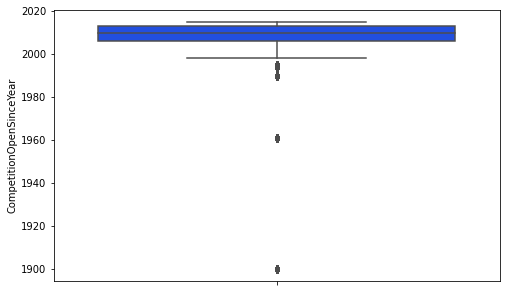

In [ ]:
#Checking the distribution of CompetitionOpenSinceYear column for observations where it is not zero 
import seaborn as sns
plt.figure(figsize = (8,5))
sns.boxplot( y = "CompetitionOpenSinceYear" , data = rossmann_sales_df[rossmann_sales_df["CompetitionOpenSinceYear"] != 0 ], palette = "bright")

We can notice above that we have some extreme outliers with values going as low as 1900 and hence we will replace values with median not mean

In [ ]:
#Replacing all the null values of CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns with median values
rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionOpenSinceYear"].isna() , rossmann_sales_df["CompetitionOpenSinceYear"].median() , rossmann_sales_df["CompetitionOpenSinceYear"])
rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionOpenSinceMonth"].isna() , rossmann_sales_df["CompetitionOpenSinceMonth"].median() , rossmann_sales_df["CompetitionOpenSinceMonth"])


In [ ]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

Now as in our dataset values for all the observations are date sensitive , we will set values of CompetitionDistance , CompetitionOpenSinceYear and CompetitionOpenSinceMonth to zero for all those observations which are of date before the time at which the nearby competitor store opened 

In [ ]:
#Iterating through all the rows and conditionally setting value of CompetitionDistance , CompetitionOpenSinceYear and CompetitionOpenSinceMonth to zero for those rows on which the condition satisfies
for index, row in rossmann_sales_df.iterrows():
  if row["Date"].year < row["CompetitionOpenSinceYear"] or(row["Date"].year == row["CompetitionOpenSinceYear"] and row["Date"].month < row["CompetitionOpenSinceMonth"]) :
    rossmann_sales_df.at[index, "CompetitionOpenSinceYear"] = 0 
    rossmann_sales_df.at[index, "CompetitionOpenSinceMonth"] = 0
    rossmann_sales_df.at[index, "CompetitionDistance"] = 0

In [ ]:
rossmann_sales_df[rossmann_sales_df["Promo2"] == 0][["Promo2SinceWeek" ,"Promo2SinceYear", "PromoInterval" ]]

,Promo2SinceWeek,Promo2SinceYear,PromoInterval
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
8,NaN,NaN,NaN
...,...,...,...
844328,NaN,NaN,NaN
844329,NaN,NaN,NaN
844334,NaN,NaN,NaN
844336,NaN,NaN,NaN


It is evident above that values of Promo2SinceWeek , Promo2SinceYear and PromoInterval are NaN only for those observations of stores which do not run Promo2 i.e stores having value of Promo2 equal to zero and so for these observations we will set null values of all the above three rows to zero as well 

In [ ]:
#Filling the null values of Promo2SinceWeek , Promo2SinceYear and PromoInterval to zero 
rossmann_sales_df["PromoInterval"] = rossmann_sales_df["PromoInterval"].fillna(0)
rossmann_sales_df["Promo2SinceWeek"] = rossmann_sales_df["Promo2SinceWeek"].fillna(0)
rossmann_sales_df["Promo2SinceYear"] = rossmann_sales_df["Promo2SinceYear"].fillna(0)

With the help of Promo2SinceWeek and Promo2SinceYear we can know when the promo2 started running at any of the 1115 store and so for observation of those dates which are of before the time Promo2 campaign started at that store we will set the value of Promo2 for those observation to zero

In [ ]:
def Promo2Running(row):

  '''Function to conditionally return different values for promo2 depending on the date for which the observation is '''

  if row["Promo2"] != 0 :
    if ( row["Date"].year < row["Promo2SinceYear"] ) or ( row["Date"].year == row["Promo2SinceYear"] and row["Date"].month < (row["Promo2SinceWeek"]//4 +1)):
      return 0
    else:
      return 1
  else:
    return 0

In [ ]:
#Applying the Promo2Running function to refine the values of Promo2 for each of the observation
rossmann_sales_df["Promo2"] = rossmann_sales_df.apply(Promo2Running , axis = 1)

In [ ]:
rossmann_sales_df["PromoInterval"] = np.where(rossmann_sales_df["Promo2"] == 0 , 0 , rossmann_sales_df["PromoInterval"])

### **Feature Engineering**

Feature engineering is basically a process in which we select and transfrom varibles into features that better represent the underlying problem to the predictive models

The goal is to create the best representation of our sample data to learn a solution to our problem at hand 

In [ ]:
def MonthsOfCompetition(row):

  '''Function to find the number of months that has passed for any store since the nearby competitor store opened'''
  
  if row["CompetitionOpenSinceYear"] != 0:
    return ((row["Date"].year - row["CompetitionOpenSinceYear"])*12 + (row["Date"].month - row["CompetitionOpenSinceMonth"]))
  else:
    return 0

In [ ]:
#Creating a new row named NumberOfMonthsFacedCompetition that will denote the number of months passed since the nearby competitor store opened
rossmann_sales_df["NumberOfMonthsFacedCompetition"] = rossmann_sales_df.apply(MonthsOfCompetition , axis = 1)

In [ ]:
#Dropping the rows CompetitionOpenSinceMonth and CompetitionOpenSinceYear from our dataset
rossmann_sales_df.drop(["CompetitionOpenSinceMonth" , "CompetitionOpenSinceYear"] , axis = 1 , inplace = True )

In [ ]:
def PromoMonth(row):

  '''Function to check if the month for which the observation is, matches with the promo2 month or not'''

  if isinstance(row["PromoInterval"], str):
    if row["Date"].strftime("%b") in row["PromoInterval"].split(","):
      return 1
    else:
      return 0
  else:
    return -1


The above function returns 1 for for those dates whose month matches with the months for which Promo2 runs in that store , 0 if the store participates in Promo2 but the month to which the observation belongs is not in the list of month for which Promo2 runs in that store and the function returns -1 if the store doesn't participates in Promo2 at all

In [ ]:
#Creating a new feature named isPromoMonth which denotes whether the Promo2 is running on that day at the store
rossmann_sales_df["isPromoMonth"] = rossmann_sales_df.apply(PromoMonth ,axis = 1)

In [ ]:
#Dropping column PromoInterval from the dataset
rossmann_sales_df.drop(["PromoInterval"] , axis=1 , inplace = True)

In [ ]:
def MonthsPromo2(row):

  '''Function to find the number of months that has passed since Promo2 started running at the store'''

  if row["Promo2"] != 0:
    return (( row["Date"].year - row["Promo2SinceYear"])*12 + (row["Date"].month - (row["Promo2SinceWeek"]//4 +1)))
  else:
    return 0

In [ ]:
#Creating a new feature named MonthsOfPromo2 to denote the number of months passed since the time Promo2 started to run on the store
rossmann_sales_df["MonthsOfPromo2"] = rossmann_sales_df.apply(MonthsPromo2 , axis = 1)

In [ ]:
#Dropping columns Promo2SinceYear and Promo2SinceWeek from the dataset
rossmann_sales_df.drop(["Promo2SinceYear" , "Promo2SinceWeek"] , axis = 1 , inplace = True )

In [ ]:
#Checking the head of the database to get a glance over all the transformation that we performed above
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,900.0,0,29.0,-1,0.0
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,90.0,0,29.0,-1,0.0
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,590.0,0,29.0,-1,0.0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,0,19.0,-1,0.0
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,18160.0,0,29.0,-1,0.0


In [ ]:
#Extracting month and year from our Date column and creating separate columns for them
rossmann_sales_df["Month"] = rossmann_sales_df["Date"].apply(lambda x : x.month)
rossmann_sales_df["Year"] = rossmann_sales_df["Date"].apply(lambda x : x.year)

In [ ]:
#Creating a new copy of our database on which we will work from hereafter
rossmann_model_df = rossmann_sales_df.copy()

In [ ]:
#Grouping our database based on Store , Month and Year and calculating mean on Sales and Customers columns 
rossmannSales_groupby = rossmann_model_df.groupby(["Store" , "Month" , "Year"]).agg({ "Sales" : "mean" , "Customers" : "mean" }).reset_index()

In [ ]:
#Sorting our grouped dataset by Store, Year and Month
grouped_df = rossmannSales_groupby.sort_values(by = [ "Store" , "Year" , "Month" ] ,ignore_index="True")
grouped_df.head()

,Store,Month,Year,Sales,Customers
0,1,1,2013,4939.653846,611.500000
1,1,2,2013,5219.625000,632.875000
2,1,3,2013,5806.760000,702.960000
3,1,4,2013,4720.360000,575.280000
4,1,5,2013,5140.217391,607.173913


The dataset above contains mean values of sales and customers for each month in the dataset for each of the store . 

In [ ]:
#Checking the shape of our grouped dataset
grouped_df.shape

(33465, 5)

In [ ]:
#Creating a list of all the stores that we have in our grouped dataset
listOfStores = grouped_df["Store"].unique()

In [ ]:
#Shifting the values of Sales and Customers column of each row by 2 places forward so that each store now has mean values of sales and customers from 2 months ago 
shifted_df = grouped_df.copy()

for storeNo in listOfStores :
  shifted_df.loc[shifted_df["Store"] == storeNo , "Sales" ] = shifted_df[shifted_df["Store"] == storeNo ]["Sales"].shift( periods=2, fill_value=0 )
  shifted_df.loc[shifted_df["Store"] == storeNo , "Customers" ] = shifted_df[shifted_df["Store"] == storeNo ]["Customers"].shift( periods = 2 , fill_value = 0)


In [ ]:
#Renaming the Sales and Customers column of our shifted dataframe to 2MonthAgoSale and 2MonthAgoCustomers respectively
shifted_df.rename(columns = {"Sales" : "2MonthAgoSale" , "Customers" : "2MonthAgoCustomers" } ,inplace = True)

In [ ]:
#Checking the head of our shifted dataset
shifted_df.head()

,Store,Month,Year,2MonthAgoSale,2MonthAgoCustomers
0,1,1,2013,0.000000,0.000
1,1,2,2013,0.000000,0.000
2,1,3,2013,4939.653846,611.500
3,1,4,2013,5219.625000,632.875
4,1,5,2013,5806.760000,702.960


As we can see shifting the column values by two places led to loss of information for the first two months of each of the store

In [ ]:
#Left merging the rossmann_model_df dataset with shifted dataset on the basis of Store, Month and Year
rossmann_model_df = pd.merge(rossmann_model_df , shifted_df , how = "left" , on = ["Store" , "Month" , "Year"])

In [ ]:
#Dropping all the observations that have zero value in their 2MonthAgoSale column
index_places1 = rossmann_model_df[rossmann_model_df["2MonthAgoSale"] == 0].index
rossmann_model_df.drop( index_places1 , inplace = True )

In [ ]:
#Creating a copy of the dataset on which we will work from hereafter
rossmann_temp_df = rossmann_model_df.copy()

In [ ]:
#One Hot encoding the columns StoreType and Assortment
rossmann_temp_df = pd.get_dummies( rossmann_temp_df , columns = ["StoreType" , "Assortment" ] , prefix = [ "StoreType" , "Assortment_type" ])

In [ ]:
#Label encoding the column StateHoliday
encoder_nums = { "StateHoliday" : { "0" : 0 , "a" : 1 , "b" : 3 , "c" : 2} } 

rossmann_temp_df = rossmann_temp_df.replace(encoder_nums)

In [ ]:
rossmann_temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2,Month,Year,2MonthAgoSale,2MonthAgoCustomers,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_type_a,Assortment_type_b,Assortment_type_c
55547,373,5,2013-03-01,4074,308,1,0,0,0,11120.0,1,31.0,0,9.0,3,2013,3795.307692,277.923077,0,0,0,1,0,0,1
55548,369,5,2013-03-01,6643,542,1,0,0,0,0.0,0,0.0,-1,0.0,3,2013,6424.153846,528.769231,0,0,0,1,0,0,1
55549,370,5,2013-03-01,7152,645,1,0,0,0,8250.0,1,149.0,0,43.0,3,2013,6823.461538,571.192308,0,0,0,1,1,0,0
55550,371,5,2013-03-01,5774,473,1,0,0,0,1970.0,0,44.0,-1,0.0,3,2013,6373.846154,514.269231,0,0,0,1,0,0,1
55551,372,5,2013-03-01,8214,759,1,0,0,0,4880.0,0,31.0,-1,0.0,3,2013,7761.884615,702.000000,0,0,0,1,0,0,1


In [65]:
#Checking the shape of dataset 
rossmann_temp_df.shape

(788643, 25)

## **Eda Section**

Now as we are done with cleaning our data and doing all the feature engineering tasks , we will now move into data analysis part of our project . Sales and Customers are the two columns on which we will center around our whole analysis

In [ ]:
from google.colab import files

In [ ]:
#Creating a copy of the dataset on which we will perform our all eda tasks
rossmann_eda_df = rossmann_sales_df.copy()

In [ ]:
#Importing the seaborn and matplotlib library for our data visualization tasks
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Setting different parameters of matplotlib and seaborn for better visualization 
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')

### At first we will try to look at relations between the DayOfWeek column with sales and customers to get to know which day of the week attracts more customers and registers highers number of sales

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

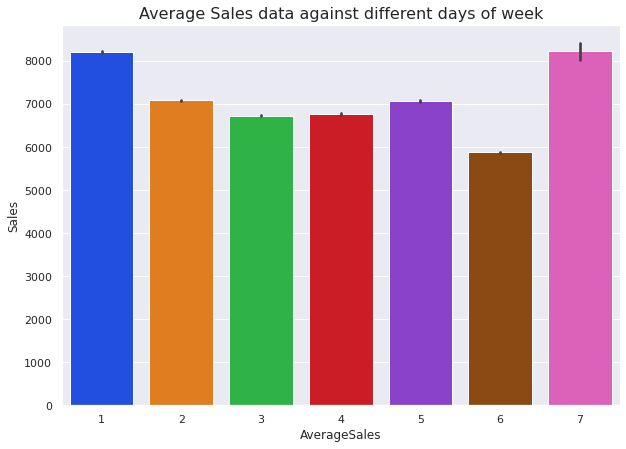

In [ ]:
#Barplot showing averages sales across different days of the week

g = sns.barplot(x='DayOfWeek',y='Sales',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.xlabel('AverageSales')
plt.title("Average Sales data against different days of week", fontsize = 16)

It is evident from the barplot that Sunday and Monday witnesses the highest number of sales while on saturday the average sales count is lowest . One of the possible reasons can be that sunday is a holiday and on monday people generally tend to buy stuffs for the rest of the week

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

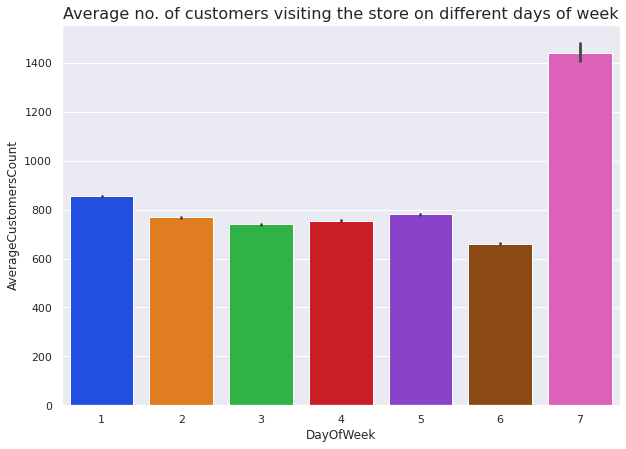

In [ ]:
#Barplot showing average number of customes across different days of the week
g = sns.barplot(x='DayOfWeek',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageCustomersCount")
plt.title("Average no. of customers visiting the store on different days of week" , fontsize = 16)

Sunday normally welcomes the most number of customers in the store as compared to all the other days of the week and this can be due to the fact that sunday is a holiday and so people like to go out for shopping 

One fact to notice is that even though the number of customers on sunday is really high (almost double as compared to other days) the figure for average sales is same as monday 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

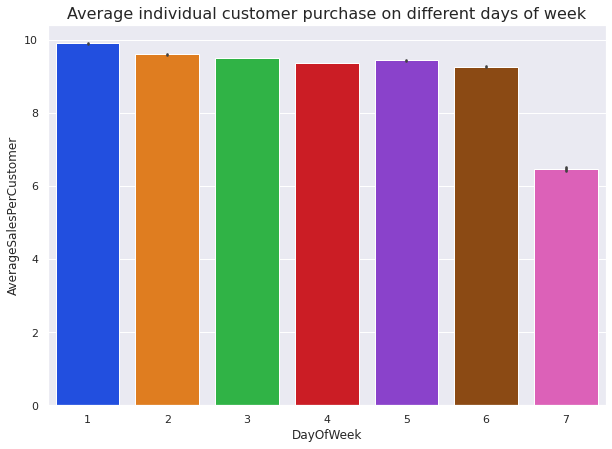

In [ ]:
#Creating a new columns AverageSalesPerCustomer by dividing Sales with Customers
rossmann_eda_df["AverageSalesPerCustomer"] = rossmann_eda_df["Sales"]/rossmann_eda_df["Customers"]

#Barplot showing AverageSalesPerCustomer across different days of the week
g = sns.barplot(x='DayOfWeek', y='AverageSalesPerCustomer' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSalesPerCustomer")
plt.title("Average individual customer purchase on different days of week" , fontsize = 16)

As we got to knew earlier that even though the average number of sales on sunday was high , the barplot above shows that the Average sales per customer on sunday is quite low which means that although a large crowd comes to store on sundays not all of them ends up buying something or the general purchase is low 

### Now we will try to find the trend acorss year and month for sales and customers column

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

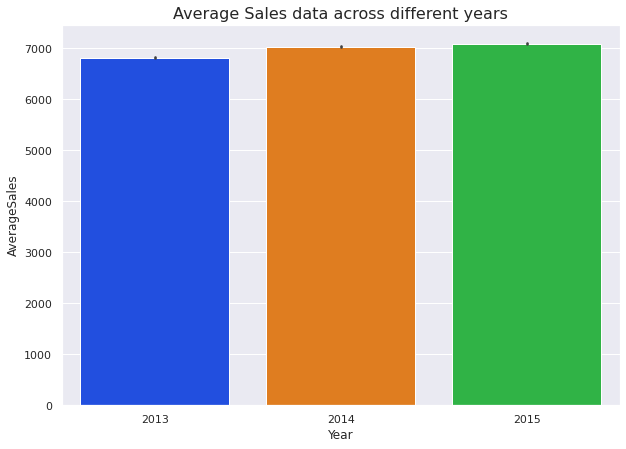

In [ ]:
#Barplot showing average sales across all the years
sns.barplot(x='Year',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSales")
plt.title("Average Sales data across different years" , fontsize = 16)

Although the difference is not much we can notice a slight increase in average sales figure with each year going forward

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

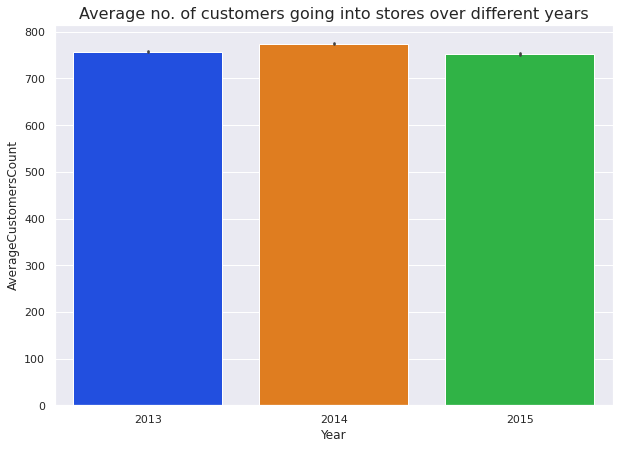

In [ ]:
#Barplot showing average no. of customers across all the stores over different years
sns.barplot(x='Year',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageCustomersCount")
plt.title("Average no. of customers going into stores over different years" , fontsize = 16)

2014 witnessed relatively higher number of customers visiting the stores

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

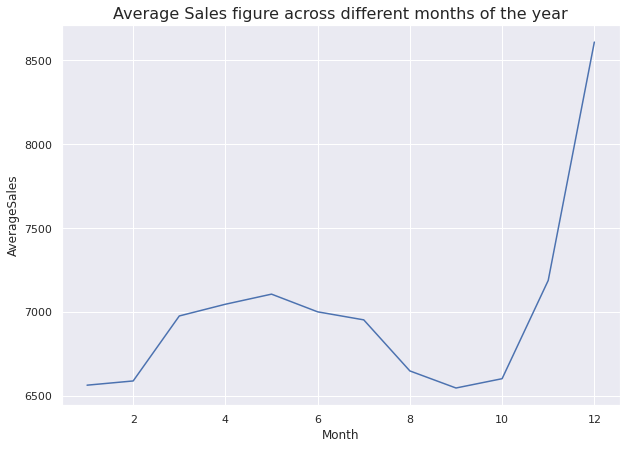

In [ ]:
#Grouping our dataset by month and calculating mean on Sales to find average sales across each month
rossmann_months_groupby = rossmann_eda_df.groupby("Month").agg({ "Sales" : "mean"}).reset_index()

#Lineplot showing variation in average sales figure across different months
sns.lineplot(x='Month',y= 'Sales' ,data = rossmann_months_groupby , palette = 'bright' ,estimator = np.mean )
plt.ylabel("AverageSales")
plt.title("Average Sales figure across different months of the year" , fontsize = 16)

Here we can see a sharp rise in number of sales towards the tail end of the year especially around november and december as the festival season starts 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

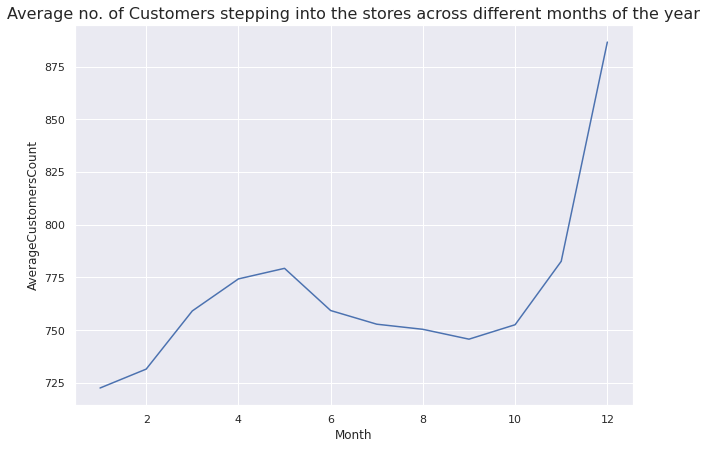

In [ ]:
#Grouping our dataset by month and calculation mean on Customers to find avearge no. of customers visiting stores for each month
rossmann_months_groupby = rossmann_eda_df.groupby("Month").agg({ "Customers" : "mean"}).reset_index()

#Lineplot showing variation in avearge number of customers visting across different months
sns.lineplot(x='Month',y= 'Customers' ,data = rossmann_months_groupby , palette = 'bright' )
plt.ylabel("AverageCustomersCount")
plt.title("Average no. of Customers stepping into the stores across different months of the year", fontsize = 16)

The pattern that we saw above in average sales can be seen here too ,from around october we can see a very sharp rise in number of customers going in stores . All in all the fag end of the year is very importand and busy period as large number of customers visit the stores and so the sales amount is also very high

### The Assortment level of the store and Store Type can also affect the sales figure and customers count and this is what we will try to look at now

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

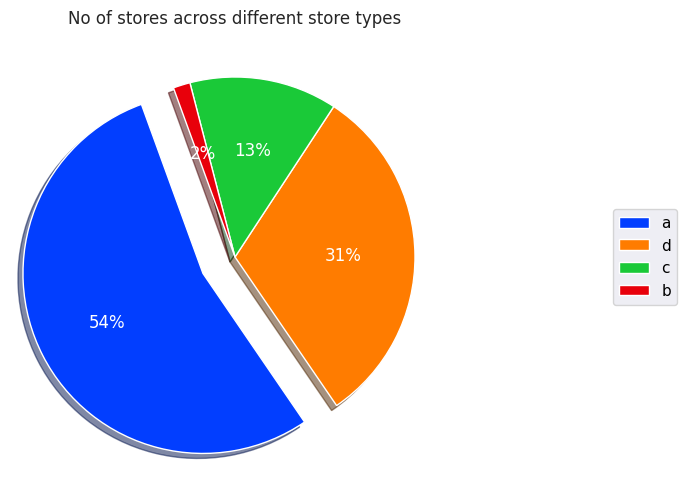

In [ ]:
#finding out the number of stores we have of each store type
rossmann_eda_df_groupby = rossmann_eda_df.groupby(["StoreType" , "Store"] , sort =False).agg({ "Date" : "first"}).reset_index()
EachStoreTypeCount = rossmann_eda_df_groupby["StoreType"].value_counts()

#Making a list of all store types
EachStoreTypeCount_list = EachStoreTypeCount.index.tolist()
#Making a list of frequency of each store type
EachStoreTypeCount_count = list(EachStoreTypeCount.values)

''' Plotting a pie char to show the percentage of store from each Store type 
    that we have in our dataset'''


totalStoreTypes = len(EachStoreTypeCount_count)

fig_1 = plt.figure(figsize=(8,5),dpi=100)
axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])
plt.rcParams['text.color'] = 'black'
colors = sns.color_palette('bright')[0:totalStoreTypes]

explode = [0]*totalStoreTypes
explode[0] = 0.2

wedges, texts, autotexts = plt.pie(EachStoreTypeCount_count, explode=explode, labels = EachStoreTypeCount_list, colors=colors, 
                                    autopct='%1.0f%%', shadow=True, startangle=110, 
                                    textprops=dict(color="w"))

plt.legend(wedges, EachStoreTypeCount_list, loc='right', bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("No of stores across different store types")

It is visible that more than half the stores in our data set are of type ***a***
followed by type ***d*** and only 2% of the store are of type ***b***

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

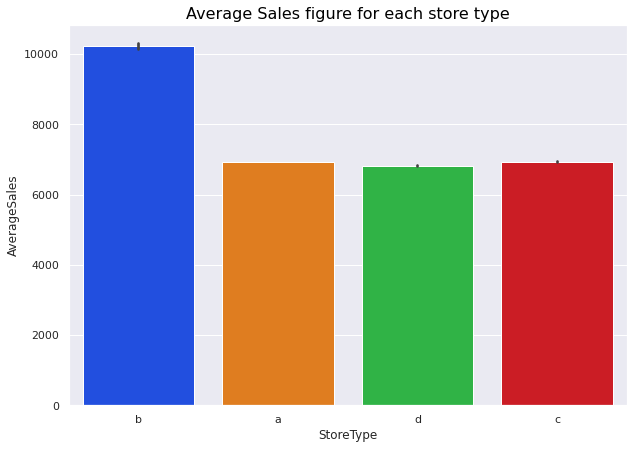

In [ ]:
#Barplot showing average number of sales for each store type
g = sns.barplot(x='StoreType',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSales")
plt.title("Average Sales figure for each store type" , fontsize = 16)

Athough our dataset has very few stores of type b as we saw in the pie chart , the barplot above shows that it is these store which had the highest number of average sales and all the other type of store can be seen having almost identical figure for average sales 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

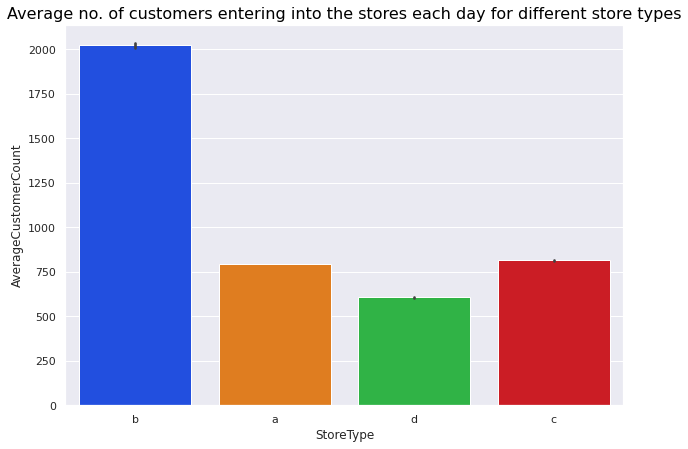

In [ ]:
#Barplot showing average no. of customers coming in stores of different store types
g = sns.barplot(x='StoreType',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageCustomerCount")
plt.title("Average no. of customers entering into the stores each day for different store types" , fontsize = 16)
plt.savefig("AverageCustomersVsStoreType.png" , bbox_inches = "tight")
files.download("AverageCustomersVsStoreType.png")

Stores of type ***b*** can be seen welcoming more than double the number of customers as compared to stores of other types , if we compare the Customers barplot with the Sales one against StoreType we can notice that as compared to the very high number of customers visiting the stores the average sales figure for stores of type ***b*** is not that high  which means the average purchase is relatively low for stores of type ***b***

In [ ]:
#Grouping our dataset based on Assortment and Store number to find the number of stores of each assortment type
rossmann_eda_df_groupby = rossmann_eda_df.groupby(["Assortment" , "Store"] , sort =False).agg({ "Date" : "first"}).reset_index()
EachAssortmentLevelCount = rossmann_eda_df_groupby["Assortment"].value_counts()
EachAssortmentLevelCount

a    593
c    513
b      9
Name: Assortment, dtype: int64

Most of the stores in our dataset has an assortment level of a (basic) and c (extended) and just 9 stores has an assortment level of b i.e Standard

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

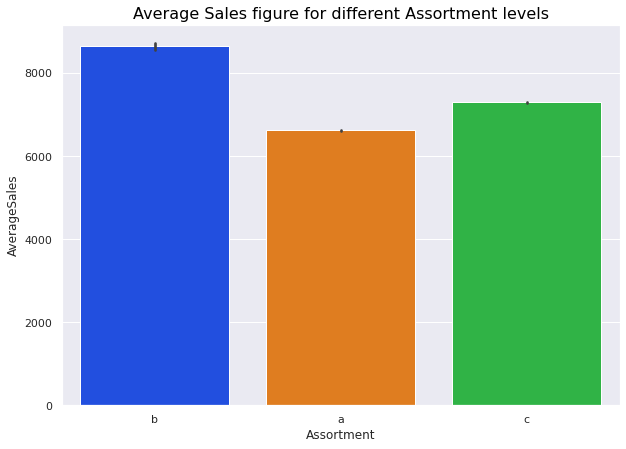

In [ ]:
#Barplot showing avearge sales figure across different assortment levels
g = sns.barplot(x='Assortment',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSales")
plt.title("Average Sales figure for different Assortment levels" , fontsize = 16)
plt.savefig("AverageSalesVsAssortment.png" , bbox_inches = "tight")
files.download("AverageSalesVsAssortment.png")

Stores which have an assortment level of b (standard) can be seen having higher number of average sales count as compared to the others . Store with basic assortment level marks the lowest number of sales

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

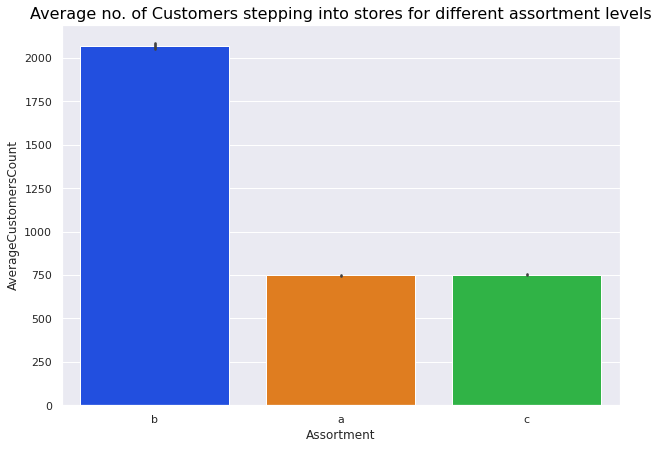

In [ ]:
#Barplot showing average customers count for different assortment levels
g = sns.barplot(x='Assortment',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageCustomersCount")
plt.title("Average no. of Customers stepping into stores for different assortment levels" , fontsize = 16)

Stores having basic and extended assortment levels on a day welcomes around 750 customers on an average whereas stores of standard assortment level has an average customers count of more than 2000

In [ ]:
#Finding the relation between assortment level and store types
rossmann_eda_groupby = rossmann_eda_df.groupby(["StoreType" , "Assortment" , "Store"] , sort=False).agg({ "Date" : "first" }).reset_index()
rossmann_eda_groupby = rossmann_eda_groupby.groupby(["StoreType" , "Assortment"] , sort =False).agg({ "Store" : "count" }).reset_index()

rossmann_eda_pivot = rossmann_eda_groupby.pivot(index = "StoreType" , columns="Assortment" , values = "Store")
rossmann_eda_pivot

Assortment,a,b,c
StoreType,,,
a,381.0,NaN,221.0
b,7.0,9.0,1.0
c,77.0,NaN,71.0
d,128.0,NaN,220.0


Text(0.5, 1.0, 'Frequency of Stores of each assortment level for different Store types')

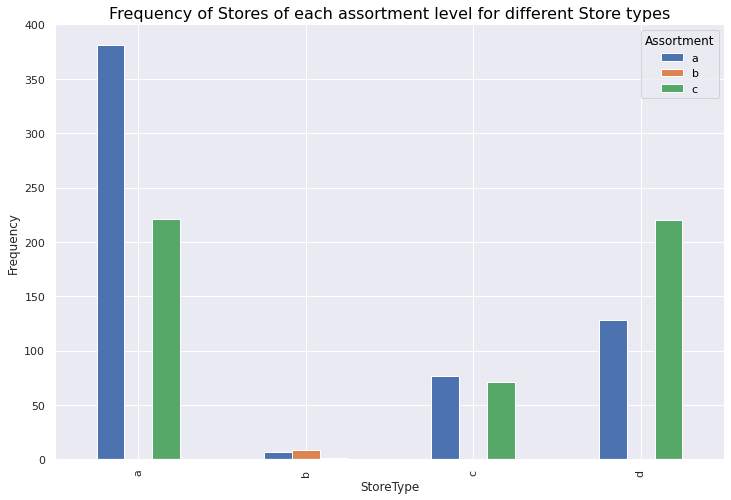

In [ ]:
plt.rcParams['figure.figsize'] = 8,5

rossmann_eda_pivot.fillna(0 , axis = 1 , inplace = True)
rossmann_eda_pivot.plot(kind="bar" , figsize=(12,8) )
plt.ylabel("Frequency")
plt.title("Frequency of Stores of each assortment level for different Store types" , fontsize = 16)

The multi barplot above shows that only stores of type b has standard level assortment and stores of all the other store types has only basic and extended level assortment

All in all we got to know that very few number of stores in our database are of standard level assortment and that too can only be found in stores of type b also these stores registers the highest number of sales . 

### We all know that sales at stores and the customers crowd are on a higher side around holidays and so now we will try to find the influence that state holidays and school holidays has on both sales and customers numbers



a = public holiday, b = Easter holiday, c = Christmas, 0 = None

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

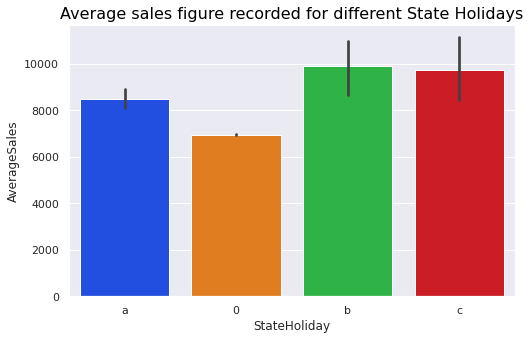

In [ ]:
##Barplot showing average sales on different State Holidays
g = sns.barplot(x='StateHoliday',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSales")
plt.title("Average sales figure recorded for different State Holidays" , fontsize = 16)

As one can expect sales are relatively higher on christmas and easter holidays as compared to all the other days . Normal public holidays can also be seen giving a slight boost to the average sales count 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

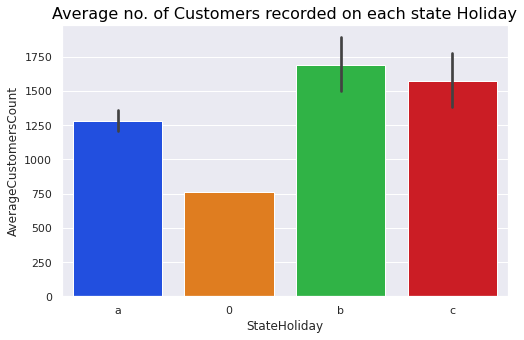

In [ ]:
#Barplot showing average no. of customers entering the stores each day on different state holidays
g = sns.barplot(x='StateHoliday',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageCustomersCount")
plt.title("Average no. of Customers recorded on each state Holiday" , fontsize = 16)

One interesting fact that can be seen on the barplot above is that average customers count on easter is higher than those on christmas and also on any state holiday the no. of customers entering the store is almost double the amount of a normal day

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

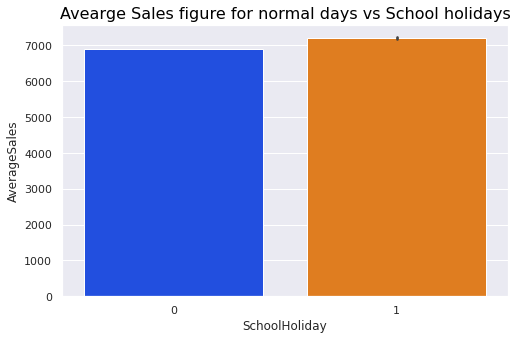

In [ ]:
#Barplot showing average sales data based on whether it is a school holiday or not
sns.barplot(x='SchoolHoliday',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright' ,estimator =np.mean )
plt.ylabel("AverageSales")
plt.title("Avearge Sales figure for normal days vs School holidays" , fontsize = 16)

Average sales on a school holiday is slightly higher than all the other days

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

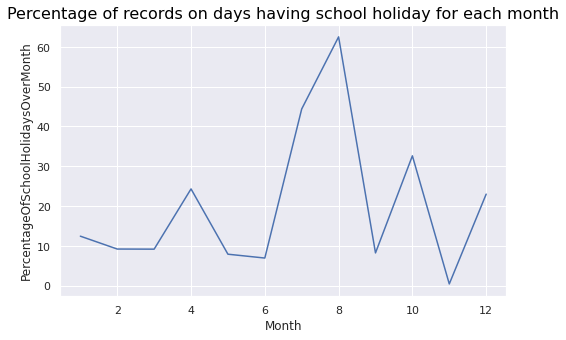

In [ ]:
#Grouping our dataset by Month and calculating the total number of school holidays for each month
school_holiday_groupby = rossmann_eda_df.groupby(["Month"] , sort = False).agg(Count =('SchoolHoliday', 'count'), Sum=('SchoolHoliday', 'sum')).reset_index()
school_holiday_groupby["PercentageOfSchoolHolidaysOverMonth"] = (school_holiday_groupby["Sum"]*100)/school_holiday_groupby["Count"]

sns.lineplot(x = "Month" , y = "PercentageOfSchoolHolidaysOverMonth" , data = school_holiday_groupby , palette = "bright")
plt.title("Percentage of records on days having school holiday for each month" , fontsize = 16)

We can see that 60 percent of the records in our dataset for the month of august are school holidays also november is the month which can be seen having least number of school holidays

### Now the rossmann stores runs different promo on their stores , some of which are continuing and consecutive and the other are just valid for a day , we will try to find the positive or negative influence these promos have on sales and customer count

-1 = store doesn't participates , 0 = store participates but currently it's not running promo 2 , 1 = store is running promo2 for the month

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

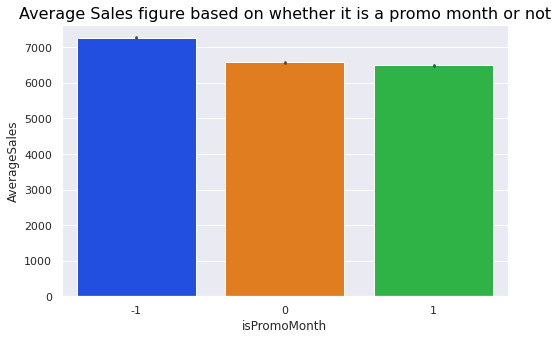

In [ ]:
#Barplot showing average sales based on whether it is a promo month or not
g = sns.barplot(x='isPromoMonth' , y='Sales',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSales")
plt.title("Average Sales figure based on whether it is a promo month or not" , fontsize = 16)

We can see that there is kind of a negative correlation between Promo2 and sales , as the averages sales figure for days on which Promo2 is running is less than those days when it isn't

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

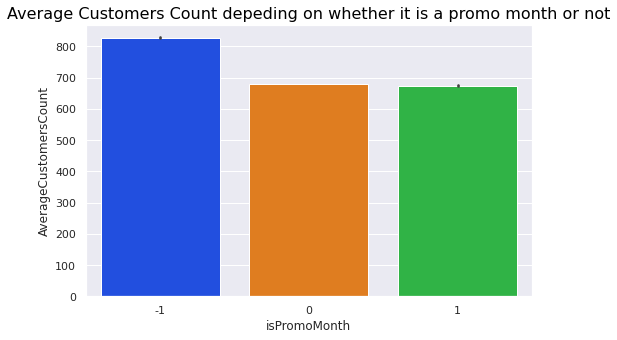

In [ ]:
#Barplot showing average customers count based on whether it is a promo month or not
g = sns.barplot(x='isPromoMonth' , y='Customers',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageCustomersCount")
plt.title("Average Customers Count depeding on whether it is a promo month or not" , fontsize = 16)

The trend for no. of customers is similar to what we saw earlier for average sales which is , if the store is running Promo2 on a day the no. of customers coming to store is less than normal

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

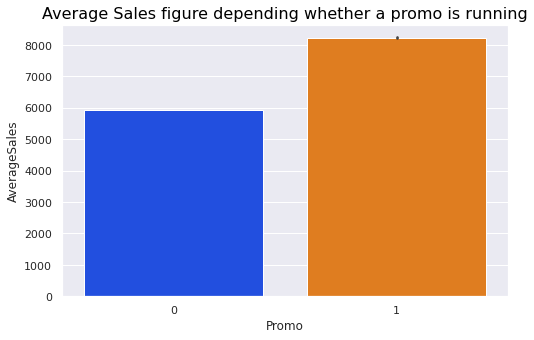

In [ ]:
#Barplot showing average sales for days when a promo is running and for days when it isn't
g = sns.barplot(x='Promo',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
plt.ylabel("AverageSales")
plt.title("Average Sales figure depending whether a promo is running" , fontsize = 16)
plt.savefig("isPromoSales.png" , bbox_inches = "tight")
files.download("isPromoSales.png")

For days when some kind of promo is running at the store the total sales for the day at the stores can be seen undergoing a significant boost as compared to the days when no promo is running

In [ ]:
#calculating the no. of days for which a promo is running at the stores for each month
promo_month = rossmann_eda_df.loc[: , ["Date" , "Year" ,"Month", "Promo"]]
promo_month["Day"] = promo_month["Date"].apply(lambda x : x.day)
promo_month.head()

,Date,Year,Month,Promo,Day
0,2013-01-01,2013,1,0,1
1,2013-01-01,2013,1,0,1
2,2013-01-01,2013,1,0,1
3,2013-01-01,2013,1,0,1
4,2013-01-01,2013,1,0,1


In [ ]:
promo_month_groupby = promo_month.groupby(["Year" , "Month" , "Day"]).agg({ "Promo" : "first"  }).reset_index().groupby(["Year" , "Month"]).agg({ "Promo" : "sum"}).reset_index()
sns.lineplot(x = "Month" , y = "Promo" , hue = "Year" , data = promo_month_groupby , palette = 'bright' )
plt.ylabel("PromoDaysFrequency")
plt.title("Number of days on which a promo is running for each month and year" , fontsize = 16)
plt.savefig("PromoDaysFrequency.png" , bbox_inches = "tight")
files.download("PromoDaysFrequency.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

we can notice 13 promo days each year in the month of july 

### At the end we will now try to visualize relation between different numerical features using scatterplot

In [ ]:
def ScatterPlotFunc(x , y, data):

  '''Function to plot a scatterplot for different numerical features of a dataset'''

  correlation = data[x].corr(data[y])
  plt.rcParams['figure.figsize'] = 10,7
  sns.set_context('paper', font_scale=1.4)
  sns.set_theme(style='darkgrid')
  sns.scatterplot(x = x ,y= y ,data = data , palette = 'bright' )
  z = np.polyfit(data[x] , data[y] , 1)
  y_hat = np.polyval( z , data[x])
  plt.plot(data[x] , y_hat ,"r--", lw=1 )
  plt.title(f'{x} vs {y} correlation :- {correlation}')

<function matplotlib.pyplot.show>

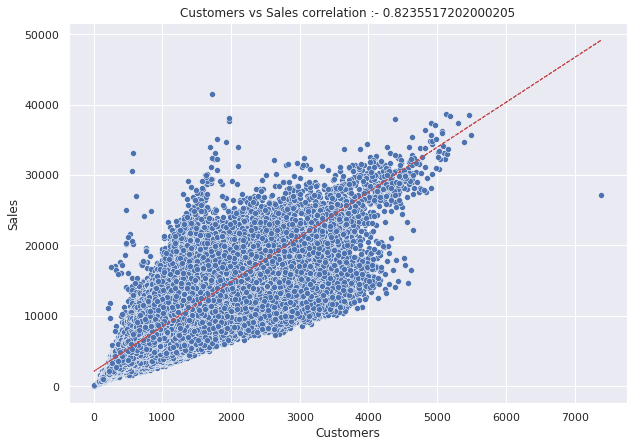

In [ ]:
#Scatterplot to show correlation between Customers and Sales
ScatterPlotFunc("Customers" , "Sales" , rossmann_eda_df )

plt.show

Customers and sales can be seen having very strong correlation of 0.82 , which basically means the proportion by which customers count increases the sales at the store rises too by same proportions

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

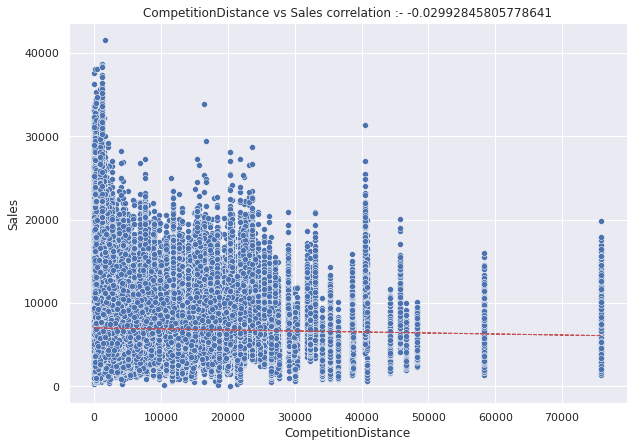

In [ ]:
#Scatter plot to show correlation between CompetitionDistance and Sales
ScatterPlotFunc("CompetitionDistance" ,"Sales" , rossmann_eda_df)

plt.show

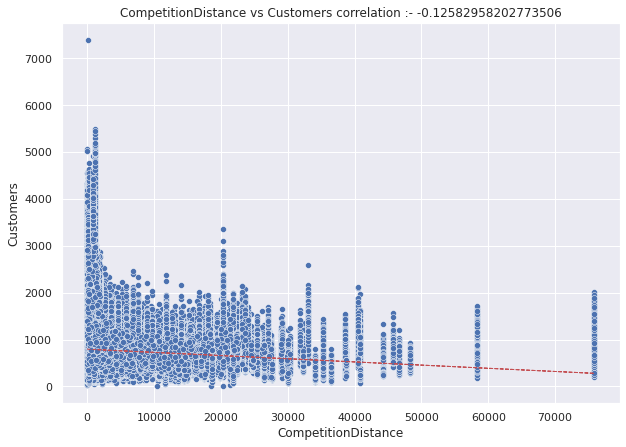

In [ ]:
#Scatterplot to show correlation between CompetitionDistance and Customers column
ScatterPlotFunc("CompetitionDistance" , "Customers" , rossmann_eda_df)

<function matplotlib.pyplot.show>

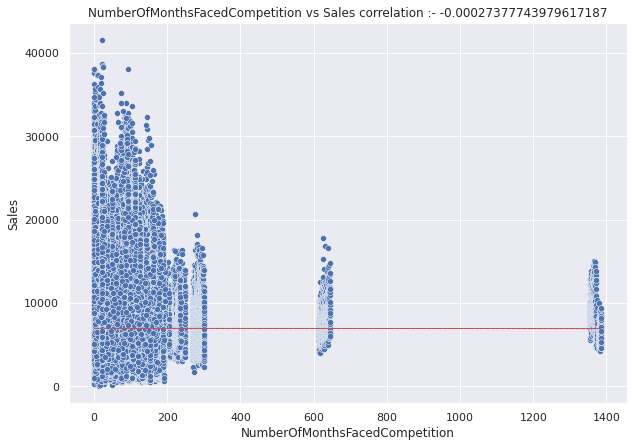

In [ ]:
#Scatterplot to show correlation between NumberOfMonthsFacedCompetition and sales
ScatterPlotFunc("NumberOfMonthsFacedCompetition" , "Sales" , rossmann_eda_df)
plt.show


## **Model Implementation**

In this section we will try to find possible multi collinearity between all the independent variable if exists and then finally apply our ml models on the final set of selected features

In [66]:
from google.colab import files

In [67]:
#Creating a list of all the numerical features in our dataset
numerical_features = [ "CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" ,"Customers" , "Sales" ,"2MonthAgoSale" ,"2MonthAgoCustomers"]

In [68]:
mask = np.triu(np.ones_like(rossmann_temp_df[numerical_features].corr()))

Text(0.5, 1.0, 'Heatmap showing correlation between all the numerical features')

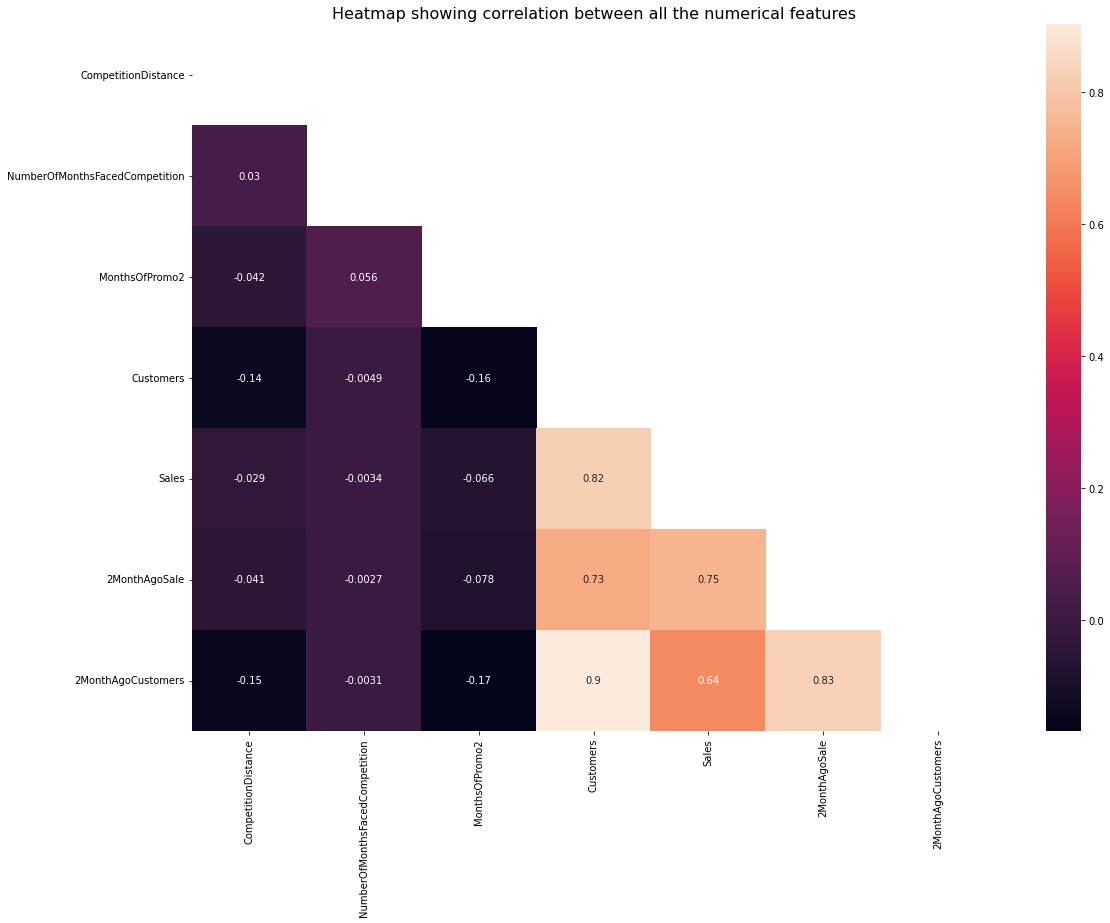

In [69]:
#Plotting a correlation heatmap for all the numerical features 
plt.figure(figsize=(18, 13))
corr = rossmann_temp_df[numerical_features].corr()
sns.heatmap(corr , annot = True , mask = mask)
plt.title("Heatmap showing correlation between all the numerical features", fontsize = 16)

There is a strong multi collinearity of customers column with 2MonthAgoSale and 2MonthAgoCustomers column which needs to be looked and treated carefully before applying the model

As for a datapoint say 2-3 weeks in future we will not have the daily Customers count with us to predict the sales for that day ,so we will drop the daily customers columns from our list of features to train our model on 

In [70]:
#Creating a list of all the features for which we want to find the collinearity between them 
correlation_features = ["CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" , "2MonthAgoSale" , "2MonthAgoCustomers"  ]

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

  '''Function to calculate variance inflation factor for different independent variables'''

  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [72]:
#Calling function calc_vif and passing the dataset with all the numerical independent features
calc_vif(rossmann_temp_df[correlation_features])

,variables,VIF
0,CompetitionDistance,1.433916
1,NumberOfMonthsFacedCompetition,1.787103
2,MonthsOfPromo2,1.454278
3,2MonthAgoSale,21.545882
4,2MonthAgoCustomers,18.197238


The vif for 2MonthAgoSale and 2MonthAgoCustomers is quite high so we will drop the 2MonthAgoCustomers column and then re calculate vif for the rest of them 

In [73]:
correlation_features = ["CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" , "2MonthAgoSale" ]

In [74]:
#Calling function calc_vif and passing the dataset with all the independent features
calc_vif(rossmann_temp_df[correlation_features])

,variables,VIF
0,CompetitionDistance,1.355844
1,NumberOfMonthsFacedCompetition,1.786912
2,MonthsOfPromo2,1.387000
3,2MonthAgoSale,2.198422


Now the vif for all the features is below 5 , so we can use all of these columns for training

In [75]:
#Creating a list of all the categorical Features 
otherFeatures = list(set(rossmann_temp_df.describe().columns) - set(numerical_features) - {"Store" , "Open"})
maskFeatures = np.triu(np.ones_like(rossmann_temp_df[otherFeatures].corr()))

Text(0.5, 1.0, 'Heatmap showing correlation between all the categorical features')

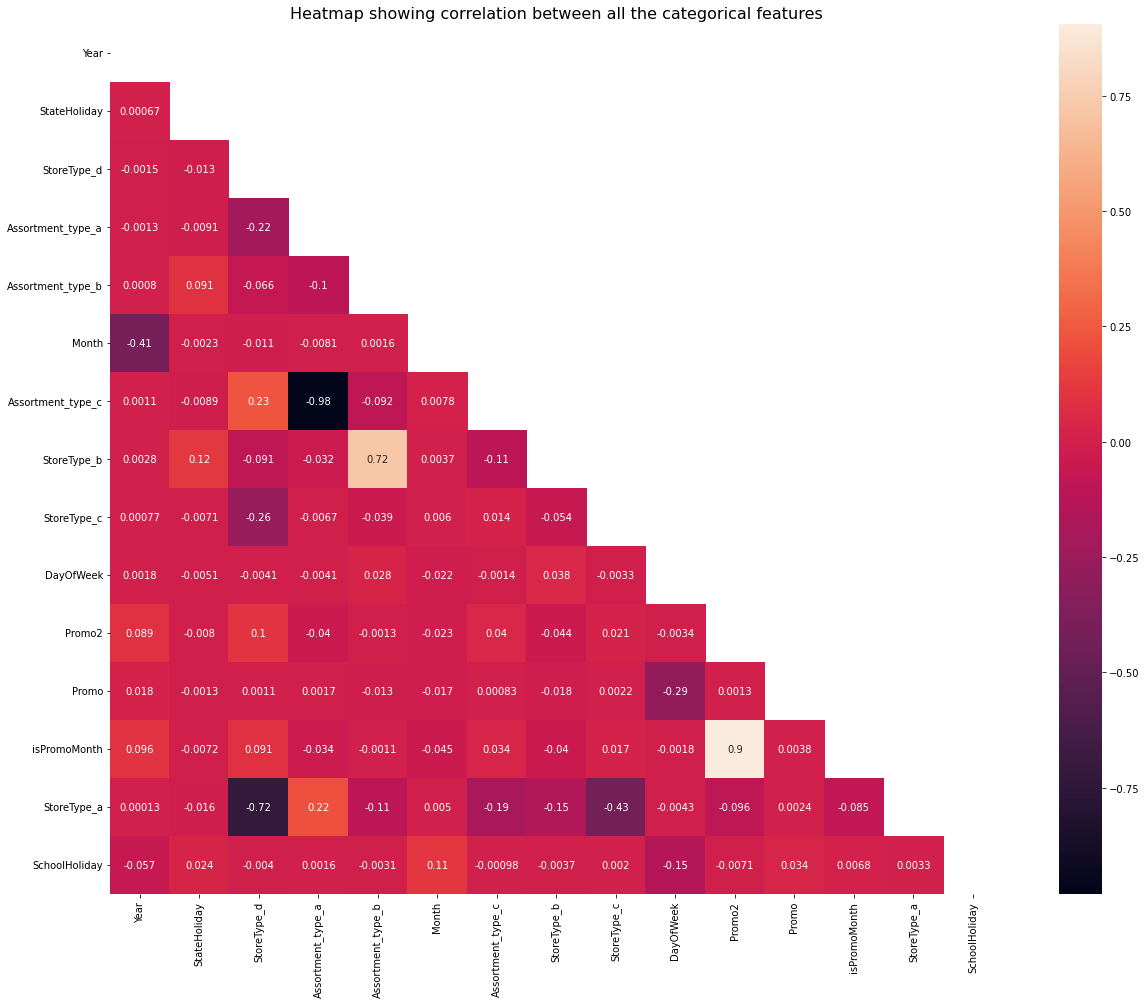

In [76]:
#Plotting a correlation heatmap for all the categorical variables 
plt.figure(figsize = (20,16))
corr2 = rossmann_temp_df[otherFeatures].corr()
sns.heatmap(corr2 , annot = True , mask = maskFeatures)
plt.title("Heatmap showing correlation between all the categorical features" , fontsize = 16)

In the heatmap we can notice a number of independent categorical features having strong multicollinearity between them like
1. **Assortment_type_a** and **Assortment_type_c** has 0.98 collinearity value
2. **Store_type_a** and **Store_type_d** has 0.72 collinearity value
3. **Promo2** and **isPromoMonth** has 0.9 collinearity value

And hence we will drop **Store_type_a** , **Assortment_type_a** and **Promo2** from our list of features on which we will train our model

In [77]:
#Checking the list of all the features in our dataset
rossmann_temp_df.describe().columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'NumberOfMonthsFacedCompetition', 'isPromoMonth', 'MonthsOfPromo2',
       'Month', 'Year', '2MonthAgoSale', '2MonthAgoCustomers', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_type_a',
       'Assortment_type_b', 'Assortment_type_c'],
      dtype='object')

In [78]:
#Creating the final list of features on which we will train our models
independent_features = rossmann_temp_df.describe().columns
independent_features = list(set(independent_features) - { "Sales" , "Customers" , "StoreType_a" , "2MonthAgoCustomers" ,"Promo2" , "Assortment_type_a" , "Open" })

In [79]:
from collections import defaultdict

In [80]:
#Importing all the necessary tools and models that we need for our predictive data analysis
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

As our dataset is time series type we can not just randomly split it into test and training sets because there is no point in learning from the future to forecast values in the past and that is why we will manually split our dataset into test and training sets

We have already sorted our dataset based on date so that as the row number increases the date also goes forward in time 

In [81]:
def train_test_split(df , dependent_feature , independent_features):
  
  '''Function to split the dataset into train and test sets such that the test 
  set only contains data points from the future as compared to the time period 
  of the ones present in training set'''

  break_point = round(len(df)*0.90)
  train_data = df.iloc[:break_point]
  test_data = df.iloc[break_point:]
  X_train = train_data[independent_features].copy()
  Y_train = train_data[dependent_feature].copy()
  X_test = test_data[independent_features].copy()
  Y_test = test_data[dependent_feature].copy()
  return (X_train ,Y_train ,X_test ,Y_test )

In [82]:
def regression_results(Y_true, Y_pred , X_test , scoring_list):

  '''Function to evaluate our model after training using different types
  of regression evaluation metrics and show all in a dataframe '''
  evaluation_dict = defaultdict(list)

  evaluation_dict["scoring"].append(scoring_list[0])
  metric_value = 1-(1-r2_score((Y_true), (Y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  evaluation_dict["Value"].append(metric_value)  
  evaluation_dict["scoring"].append(scoring_list[1])
  metric_value = np.sqrt(mean_squared_error(Y_true , Y_pred))
  evaluation_dict["Value"].append(metric_value)

  for scoring_metric in scoring_list[2:]:
    evaluation_dict["scoring"].append(scoring_metric.__name__)
    metric_value = scoring_metric((Y_true), (Y_pred))
    evaluation_dict["Value"].append('{:f}'.format(metric_value))

  evaluation_df = pd.DataFrame(evaluation_dict)
  return evaluation_df

In [83]:
def diffPlot(Y_true ,Y_pred):

  '''Function to plot predicted values and actual values of dependent variable on the same graph'''

  plt.figure(figsize=(8,5))
  plt.plot((Y_pred))
  plt.plot(((Y_true)))
  plt.legend(["Predicted","Actual"])
  plt.show()

In [84]:
#Importing all the regression evaluation metrics
from sklearn.metrics import mean_squared_error , mean_absolute_error ,r2_score , mean_squared_log_error ,median_absolute_error , max_error , mean_absolute_percentage_error

#Creating a list of the evaluation metrics
scoring_list = [ "adjusted_R2" , "root_mean_squared_error" , mean_squared_error , mean_absolute_error ,r2_score, mean_squared_log_error , median_absolute_error , max_error , mean_absolute_percentage_error]

### **Trainnig Ridge regression model on our dataset** 

In [96]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [97]:
#Scaling down all of our features 
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
#Initializing our Ridge regression model function by passing different hyper parameters
ridge  = Ridge(alpha= 100 , max_iter= 3000)

#Fitting our data on the model
ridge.fit(X_train, Y_train)

Ridge(alpha=100, max_iter=3000)

In [99]:
#Calculating the R2 score on our training dataset
ridge.score(X_train , Y_train)

0.7120018687571449

In [100]:
#Predicting values of our dependent variable on the test dataset
Y_pred_ridge = ridge.predict(X_test)

#Calling regression_results function to evaluate our model performance
ridge_evaluation_df = regression_results(Y_test , Y_pred_ridge , X_test , scoring_list)
ridge_evaluation_df

,scoring,Value
0,adjusted_R2,0.788448
1,root_mean_squared_error,1402.49
2,mean_squared_error,1966985.792867
3,mean_absolute_error,1029.125274
4,r2_score,0.788493
5,mean_squared_log_error,0.040001
6,median_absolute_error,811.107799
7,max_error,31013.694768
8,mean_absolute_percentage_error,0.159545


As we can see our scores for ridge regression are very ordinary all around 

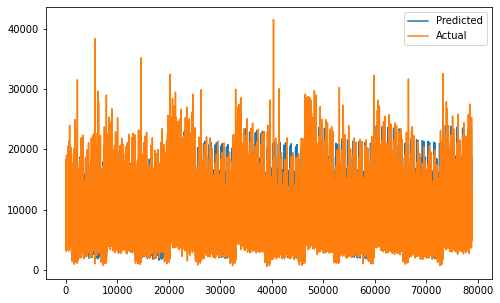

In [101]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values
diffPlot(Y_test , Y_pred_ridge)

We can notice in the graph that our simple ridge regression model is underfitting our data and is finding it hard to predict the highs and lows of sales

**Performing hyper parameter tuning on our Ridge Regression model for better accuracy**

In [ ]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [ ]:
#Initializing our ridge regression function 
ridge = Ridge()

#Calling TimeSeriesSplit function to split our dataset into two sets, each with a test_size of 59104 rows which equal to almost 6 weeks of data
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

#Calling our GridSearchCV function with a list of different parameters and using r2 as our scoring metric to evaluate different models
parameters = {'alpha': [1e-6 , 1e-7 , 1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,50,60,100,1000]}
ridge_regressor = GridSearchCV(ridge , param_grid = parameters, scoring= 'r2' , cv=tscv)
ridge_regressor.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=Ridge(),
             param_grid={'alpha': [1e-06, 1e-07, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100,
                                   1000]},
             scoring='r2')

In [ ]:
ridge_regressor.best_params_

{'alpha': 1000}

In [ ]:
#Predicting values of our dependent variable sales using the test data points after performing hyper parameter tuning
Y_pred_ridge_grid = ridge_regressor.predict(X_test)

#Calling regression_results function to evaluate our model performance after performing hyper parameter tuning for the model
ridge_evaluation_grid_df = regression_results(Y_test , Y_pred_ridge_grid , X_test , scoring_list)
ridge_evaluation_grid_df

,scoring,Value
0,adjusted_R2,0.776598
1,root_mean_squared_error,1441.24
2,mean_squared_error,2077159.675906
3,mean_absolute_error,1054.624064
4,r2_score,0.776646
5,mean_squared_log_error,0.042154
6,median_absolute_error,836.582345
7,max_error,31381.081380
8,mean_absolute_percentage_error,0.166024


As we can see hyperparameter tuning is not helping our scores much 

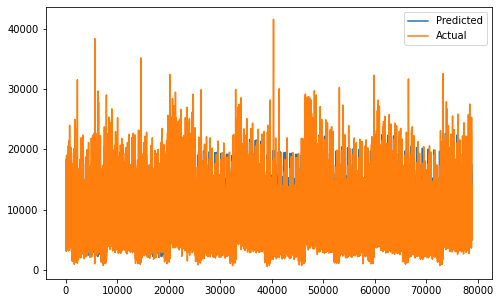

In [ ]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values
diffPlot(Y_test , Y_pred_ridge_grid)

### **Training Decision Tree model on our dataset**

In [102]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [110]:
#Initializing our DecisionTreeRegressor model function with default hyper parameters
decision_reg = DecisionTreeRegressor(criterion = "squared_error" , max_depth = 14 , max_features = "auto")

#Fitting our data on the model
decision_reg.fit(X_train , Y_train)

DecisionTreeRegressor(max_depth=14, max_features='auto')

In [111]:
#Calculating the R2 score on our training dataset
decision_reg.score(X_train , Y_train)

0.8687138479588157

In [124]:
#Predicting values of our dependent variable on the test dataset
Y_pred_dec = decision_reg.predict(X_test)

#Calling regression_results function to evaluate our model performance 
dec_evaluation_df = regression_results(Y_test , Y_pred_dec , X_test , scoring_list)
dec_evaluation_df

,scoring,Value
0,adjusted_R2,0.840151
1,root_mean_squared_error,1219.12
2,mean_squared_error,1486258.028002
3,mean_absolute_error,855.936818
4,r2_score,0.840185
5,mean_squared_log_error,0.029266
6,median_absolute_error,628.314798
7,max_error,32670.652174
8,mean_absolute_percentage_error,0.131013


As compared to ridge regression model our overall scores for decision tree model are much improved

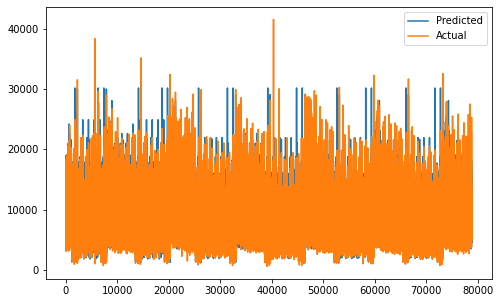

In [113]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values for GradientBoostRegression model
diffPlot(Y_test , Y_pred_dec)

As compared to the Ridge Regression model this one is better predicitng our sales digures as is visible from the graph above as well

**Performing hyper parameter tuning on our Decision Tree Regressor model for better accuracy**

In [114]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [116]:
#Creating an instance of GradientBoostRegressor
model = DecisionTreeRegressor()

#Spliting our data to perform cross validation on
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

# Hyperparameter Grid
grid_values = {
    "max_depth" : [ 12,14,15,16 ],
    "min_samples_split" : [ 2,3,4],
    "min_samples_leaf" : [1 , 2 ,4]
}

#Using grid search function to find the best set of hyperparameters
decGridSearch = GridSearchCV( estimator = model , param_grid = grid_values , scoring = 'neg_root_mean_squared_error' , cv = tscv)
decGridSearch.fit(X_train , Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [12, 14, 15, 16],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 4]},
             scoring='neg_root_mean_squared_error')

In [117]:
#Getting the best neg root mean squared eror score achieved using all the possible combination of hyper parameters
decGridSearch.best_score_

-1385.0332968627863

In [118]:
#Checking the best set of hyper parameters for Decision Tree Regressor
decGridSearch.best_params_

{'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 4}

In [120]:
#Predicting values of daily sales for the test data points
Y_pred_dec_grid = decGridSearch.predict(X_test)

#Calling regression_results function to evaluate our GradientBoostRegressor model performance after performing hyper parameter tuning
dec_evaluation_grid_df = regression_results(Y_test ,Y_pred_dec_grid , X_test , scoring_list)
dec_evaluation_grid_df

,scoring,Value
0,adjusted_R2,0.843181
1,root_mean_squared_error,1207.51
2,mean_squared_error,1458077.957270
3,mean_absolute_error,860.843264
4,r2_score,0.843215
5,mean_squared_log_error,0.030865
6,median_absolute_error,637.366516
7,max_error,32666.941429
8,mean_absolute_percentage_error,0.133662


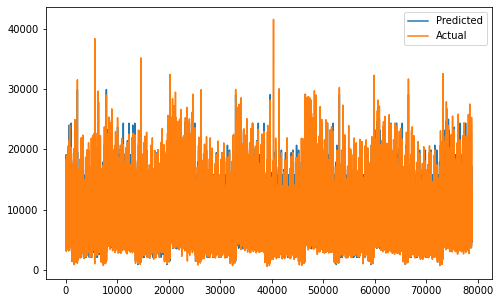

In [121]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values
diffPlot(Y_test , Y_pred_dec_grid)

**Residual Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


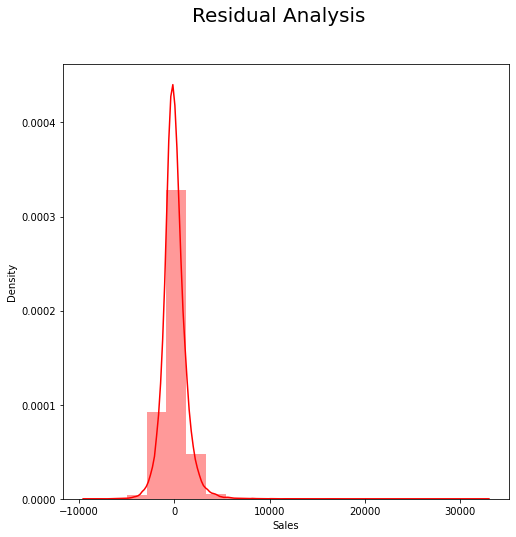

In [122]:
#Resuldual Analysis
fig=plt.figure(figsize=(8,8))
  
sns.distplot(((Y_test)- (Y_pred_dec_grid)),bins=20,color='r')

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)   
plt.savefig("GbResidualAnalysis" , bbox_inches = "tight")

Text(0, 0.5, 'residuals')

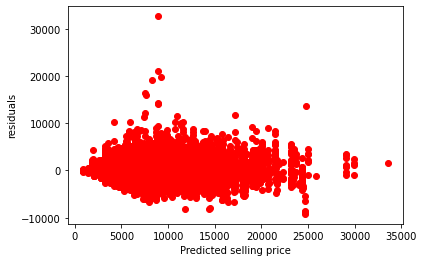

In [123]:
# Heteroscadacity
plt.scatter((Y_pred_dec_grid) , (Y_test) - (Y_pred_dec_grid) , c='r')
plt.xlabel('Predicted selling price')
plt.ylabel('residuals')

### **Training Gradient Boosting Regressor model on our dataset**

In [125]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [126]:
#Creating an instance of GradientBoostingRegressor with default hyper parameters
gb_regressor = GradientBoostingRegressor()

#Fitting our data on the model
gb_regressor.fit(X_train , Y_train)

GradientBoostingRegressor()

In [127]:
##Calculating the R2 score on our training dataset
gb_regressor.score(X_train, Y_train)

0.8137094297378727

In [128]:
#Predicting values of daily sales for the test data points
Y_pred_gb = gb_regressor.predict(X_test)

#Calling regression_results function to evaluate our model performance 
gb_evaluation_df = regression_results(Y_test , Y_pred_gb , X_test , scoring_list)
gb_evaluation_df

,scoring,Value
0,adjusted_R2,0.841769
1,root_mean_squared_error,1212.93
2,mean_squared_error,1471207.983226
3,mean_absolute_error,860.760430
4,r2_score,0.841803
5,mean_squared_log_error,0.031538
6,median_absolute_error,639.147700
7,max_error,32003.272988
8,mean_absolute_percentage_error,0.134931


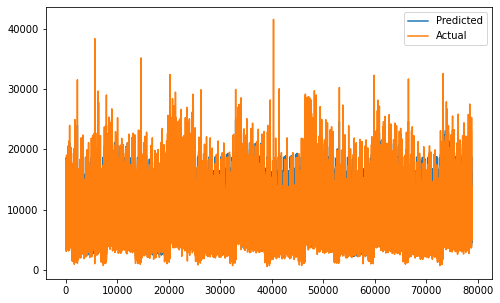

In [129]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values for GradientBoostingRegressor model
diffPlot(Y_test , Y_pred_gb)

**Performing hyper parameter tuning on our Gradient Boosting Regressor model for better accuracy**

In [ ]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [ ]:
# The number of boosting stages to perform
n_estimators = [125,150]

# Maximum depth of trees
max_depth = [3,5]

# Minimum samples required to split the node
min_samples_split = [2,4]

# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split
              }

# Creating an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor()

#Spliting our data to perform cross validation on
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

# Grid search
gb_grid = GridSearchCV(estimator = gb_model,
                       param_grid = param_dict,
                       cv = tscv, scoring='neg_root_mean_squared_error')

gb_grid.fit(X_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5], 'min_samples_split': [2, 4],
                         'n_estimators': [125, 150]},
             scoring='neg_root_mean_squared_error')

In [ ]:
##Calculating the R2 score on our training dataset
gb_grid.score(X_train, Y_train)

-1202.7647598459998

In [ ]:
#Getting the best neg root mean squared eror score achieved using all the possible combination of hyper parameters
gb_grid.best_score_

-1296.2644719717505

In [ ]:
gb_grid.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}

In [ ]:
#Predicting values of daily sales for the test data points
Y_pred_grid_gb = gb_grid.predict(X_test)

#Calling regression_results function to evaluate our GradientBoostingRegressor model performance after performing hyper parameter tuning
gb_tuned_evaluation_df = regression_results(Y_test , Y_pred_grid_gb , X_test , scoring_list)
gb_tuned_evaluation_df

,scoring,Value
0,adjusted_R2,0.851213
1,root_mean_squared_error,1176.18
2,mean_squared_error,1383404.989497
3,mean_absolute_error,860.547503
4,r2_score,0.851245
5,mean_squared_log_error,0.031278
6,median_absolute_error,656.958372
7,max_error,31919.250183
8,mean_absolute_percentage_error,0.139169


Tuning the hyperparameters has led to slight better model peroformance in case of Gradient Boosting Regressor model

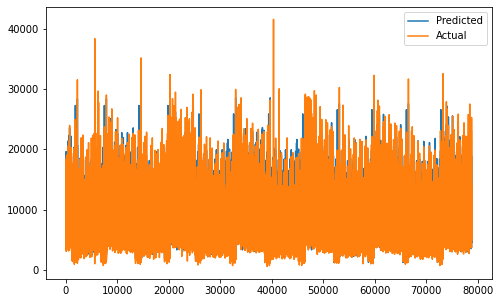

In [ ]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values for GradientBoostingRegressor model after performing hyper parameter tuning
diffPlot(Y_test , Y_pred_grid_gb)

**Residual Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

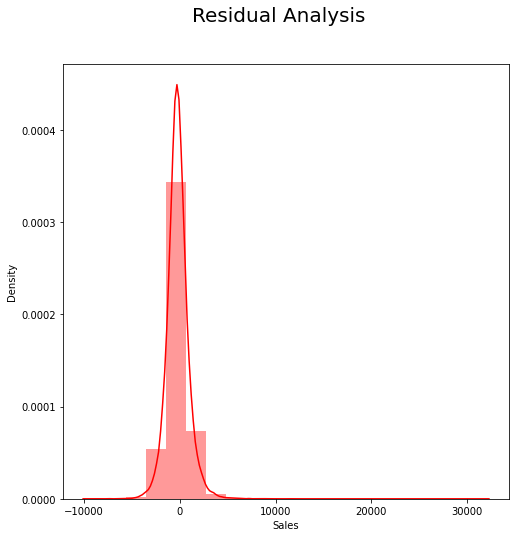

In [ ]:
#Resuldual Analysis
fig=plt.figure(figsize=(8,8))
  
sns.distplot(((Y_test)- (Y_pred_grid_gb)),bins=20,color='r')

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)   
plt.savefig("GBResidual.png" , bbox_inches = "tight")
files.download("GBResidual.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

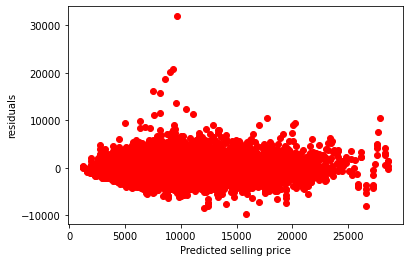

In [ ]:
# Heteroscadacity
plt.scatter((Y_pred_grid_gb) , (Y_test) - (Y_pred_grid_gb) , c='r')
plt.xlabel('Predicted selling price')
plt.ylabel('residuals')
plt.savefig("GBhetero.png" , bbox_inches = "tight")
files.download("GBhetero.png")

**Feature importance**

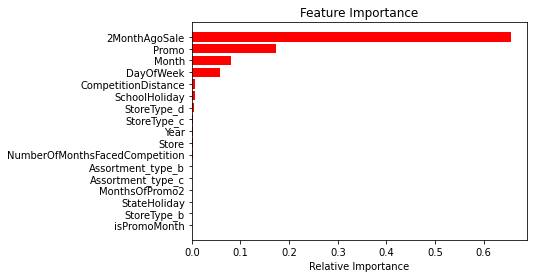

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting a horizontal importance plot

importances = gb_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [independent_features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()
plt.savefig("hello.png")

### **Training Random Forest Regressor model on our dataset**

In [130]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [131]:

#Creating an instance of RandomForestRegressor with default hyper parameters
rf_regressor = RandomForestRegressor()

#Fitting our data on the model
rf_regressor.fit(X_train , Y_train)

RandomForestRegressor()

In [132]:
##Calculating the R2 score on our training dataset
rf_regressor.score(X_train, Y_train)

0.9523793216655968

In [133]:
#Predicting values of daily sales for the test data points
Y_pred_rf = rf_regressor.predict(X_test)

#Calling regression_results function to evaluate our model performance 
rf_evaluation_df = regression_results(Y_test , Y_pred_rf , X_test , scoring_list)
rf_evaluation_df

,scoring,Value
0,adjusted_R2,0.871691
1,root_mean_squared_error,1092.24
2,mean_squared_error,1192996.632150
3,mean_absolute_error,779.209680
4,r2_score,0.871719
5,mean_squared_log_error,0.022216
6,median_absolute_error,578.876619
7,max_error,32906.329167
8,mean_absolute_percentage_error,0.117298


There is a slight boost in our overall scores for Random Forest model as compared to all the other models we tried before

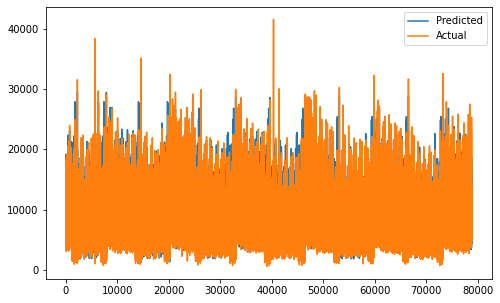

In [134]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values for RandomForestRegressor model
diffPlot(Y_test , Y_pred_rf)

In the plot above we can see that our prediction are matching the highs and lows of the sales figure quite accurately

**Performing hyper parameter tuning on our Random Forest Regressor model for better accuracy**

In [85]:
#Calling our train_test_split function to get the train and test splits of our data
X_train ,Y_train ,X_test ,Y_test = train_test_split( rossmann_temp_df, "Sales" , independent_features)

In [86]:
# Number of trees
n_estimators = [125,135]

# Maximum depth of trees
max_depth = [17,18]

# Minimum samples required to split the node
min_samples_split = [2,4]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split
              }

# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()

#Spliting our data to perform cross validation on
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

# Grid search
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict,
                       cv = tscv, scoring='neg_root_mean_squared_error')

rf_grid.fit(X_train,Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [17, 18], 'min_samples_split': [2, 4],
                         'n_estimators': [125, 135]},
             scoring='neg_root_mean_squared_error')

In [87]:
##Calculating the R2 score on our training dataset
rf_grid.score(X_train, Y_train)

-875.1373202550075

In [88]:
#Getting the best neg root mean squared eror score achieved using all the possible combination of hyper parameters
rf_grid.best_score_

-1255.9098796448236

In [89]:
rf_grid.best_params_

{'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 125}

In [91]:
#Predicting values of daily sales for the test data points
Y_pred_grid_rf = rf_grid.predict(X_test)

#Calling regression_results function to evaluate our RandomForestRegressor model performance after performing hyper parameter tuning
rf_evaluation_grid_df = regression_results(Y_test , Y_pred_grid_rf , X_test, scoring_list)
rf_evaluation_grid_df

,scoring,Value
0,adjusted_R2,0.87414
1,root_mean_squared_error,1081.77
2,mean_squared_error,1170228.055023
3,mean_absolute_error,773.688772
4,r2_score,0.874167
5,mean_squared_log_error,0.022752
6,median_absolute_error,578.474050
7,max_error,32958.267500
8,mean_absolute_percentage_error,0.117105


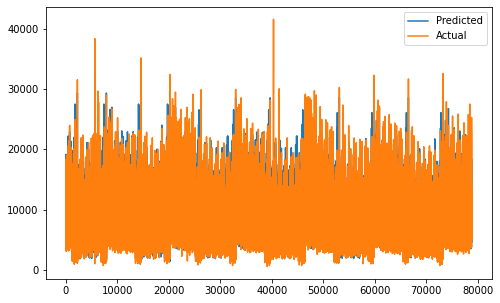

In [92]:
Y_test.reset_index(drop = True , inplace = True)

#Visualizing our predicted values of sales for the day against the true values for RandomForestRegressor model after performing hyper parameter tuning
diffPlot(Y_test , Y_pred_grid_rf)

**Residual Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Residual Analysis')

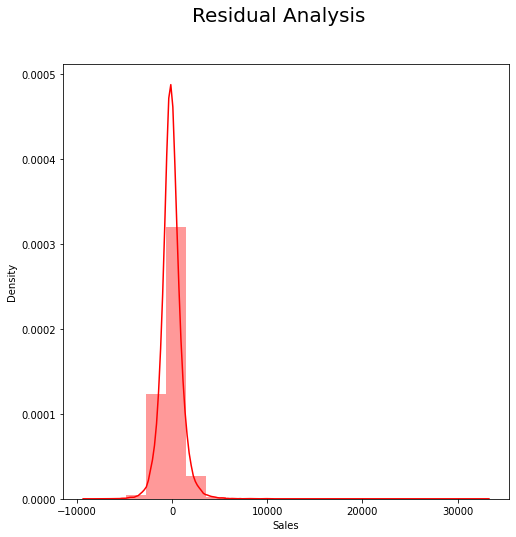

In [93]:
#Resuldual Analysis
fig=plt.figure(figsize=(8,8))
  
sns.distplot(((Y_test)- (Y_pred_grid_rf)),bins=20,color='r')

#Plot Label
fig.suptitle('Residual Analysis', fontsize = 20)   


Text(0, 0.5, 'residuals')

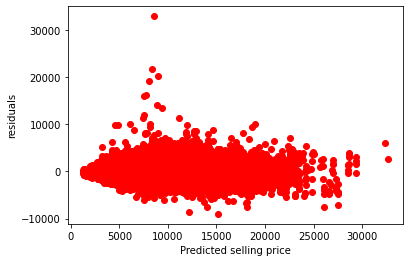

In [94]:
# Heteroscadacity
plt.scatter((Y_pred_grid_rf) , (Y_test) - (Y_pred_grid_rf) , c='r')
plt.xlabel('Predicted selling price')
plt.ylabel('residuals')

**Feature importance**

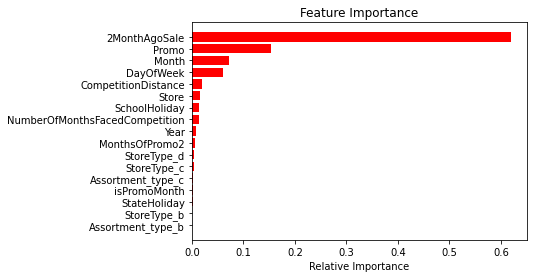

In [95]:
#Plotting a horizontal importance plot

importances = rf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [independent_features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()


As visible in the graph above 2MonthAgoSale is the most important feature with a relative importance value of 0.6 , other features of noticeabe importance are Promo , Month , DayOfWeek and CompetitionDistance

###**Comparing all the model evaluated till now**

In [135]:
#Creating a list of all the evaluation df created till now for different models
evaluation_df = [ ridge_evaluation_df , dec_evaluation_df , gb_evaluation_df , rf_evaluation_df ]

#Creating an empty list in which to store the transposed evaluaiton dfs
transposed_evaluation_df = []

In [137]:
#Transposing all the evaluation df that we have created till now and saving all of them in transposed_evaluation_df
for e_df in evaluation_df:
  e_df = e_df.set_index("scoring")
  e_df.index.names = [None]
  e_df = e_df.transpose()
  transposed_evaluation_df.append(e_df)

In [138]:
#Creating a list of all the model names that we have evaluated till now
model_names = ["Ridge Regression" , "Decision Tree" ,  "Gradient Boost" , "Random Forest"]

#Concatenating all the individual transposed evaluation df into single df 
all_model_evaluation_df = pd.concat(transposed_evaluation_df , axis = 0)
all_model_evaluation_df.insert(0 , "Model_Name" , model_names)
all_model_evaluation_df.reset_index( drop = True , inplace = True)
all_model_evaluation_df

,Model_Name,adjusted_R2,root_mean_squared_error,mean_squared_error,mean_absolute_error,r2_score,mean_squared_log_error,median_absolute_error,max_error,mean_absolute_percentage_error
0,Ridge Regression,0.788448,1402.49,1966985.792867,1029.125274,0.788493,0.040001,811.107799,31013.694768,0.159545
1,Decision Tree,0.840151,1219.12,1486258.028002,855.936818,0.840185,0.029266,628.314798,32670.652174,0.131013
2,Gradient Boost,0.841769,1212.93,1471207.983226,860.760430,0.841803,0.031538,639.147700,32003.272988,0.134931
3,Random Forest,0.871691,1092.24,1192996.632150,779.209680,0.871719,0.022216,578.876619,32906.329167,0.117298


It is clear that random forest is our best performing model if we compares its overall scores against all the others

## **Conclusion**

So with this we are finally done with our project *Rossmann Sales Prediction* .At first we analysed carefully both the dataset that were provided to us , understanding each and every feature and what role it can play in affecting the sales price for the day , then we handled all the null values and performed some necessary operation on few of the columns making sure that all the columns best correlate with the dependent variable 

We also did a fair bit of feature engineering in order to create the best representation of our sample data on which we can fit different models later on and then we deep dived into the eda part where with the help of data visualization library we tried to better understand the relation between our dependent variable i.e *Sales* and all of our independent variables , last but not the least we filtered out the variables that had high multicollineartiy between them 

Finally our dataset was ready for model implementation and evaluation . We in total fitted 4 models on our dataset of different levels of complexity and also did hyperparamter tuning for all of them . Of all the 4 models we found that Random Forest gave the best overall scores .